# Cardiovascular Event Detection for Patients

<img src="./images/header.jpg" 
    Width="1000">

## 1. Business understanding

The objective of this project is to develop a machine learning model that can predict the susceptibility of patients to heart disease based on several factors that can be monitored during health checks. This can be used as an early detection mechanism to improve patient outcomes and/or to prevent the occurance of such disease by doing more frequenct health checks or through life style changes. To this end, we use the [UCI Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease) to develop, train and evaluate a machine learning model. 

The notebook is organized as follows: in Section 2, I use descriptive statistics and several visualizations to examine the dataset, develop a better understanding of the features and identify any cleaning or modifications that may be required. Next, I clean the data and address any missing values to prepare the data for building a model. In Section 3, several machine learning models (logistic regression, decision trees and in the end an ensemble method, a random forest method) are built, trained and evaluated based on unified performance metrics. The best model is identified. Section 4 summarizes the performance of the models built in tables and makes three recommendations to stakeholders based on the findings of this study. Section 5 lists the limitations of the current study as well as avenues that one may explore to improve the performance of the model. 

## 2. Explaratory Data Analysis

In [61]:
%reset
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import randint
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
# from typings import 

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [62]:
def read_data(file_name: str) -> pd.DataFrame:
    """ This function reads a file from the UIC heart disease repository and returns the result in a dataframe. 
    Args:
        file_name: a string containing the file name

    Returns:
        df: a dataframe containing the data on file. 
    """
    # read the data; replace "?"s with NaNs
    df = pd.read_csv("./unzipped_data/"+file_name, header = None, na_values = ["?"])
    
    # column headers can be obtained from https://archive.ics.uci.edu/dataset/45/heart+disease
    header_dicts = {0: "age", 
                    1: "sex", 
                    2: "cp", 
                    3: "trestbps",
                    4: "chol",
                    5: "fbs",
                    6: "restecg",
                    7: "thalach",
                    8: "exang",
                    9: "oldpeak",
                    10: "slope",
                    11: "ca",
                    12: "thal",
                    13: "num"}
    df.rename(columns=header_dicts, inplace=True)
    return df 

In [63]:
def show_summary(df: pd.DataFrame):
    print("Number of missing values in each attribute:")
    display(df.isna().sum())
    display(df.info())
    display(df.head())
    return None

In [64]:
df_cleveland = read_data("processed.cleveland.data")
df_switzerland = read_data("processed.switzerland.data")
df_hungary = read_data("processed.hungarian.data")
df = pd.concat([df_cleveland, df_switzerland, df_hungary])
show_summary(df)

Number of missing values in each attribute:


age           0
sex           0
cp            0
trestbps      3
chol         23
fbs          83
restecg       2
thalach       2
exang         2
oldpeak       6
slope       207
ca          413
thal        320
num           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Index: 720 entries, 0 to 293
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       720 non-null    float64
 1   sex       720 non-null    float64
 2   cp        720 non-null    float64
 3   trestbps  717 non-null    float64
 4   chol      697 non-null    float64
 5   fbs       637 non-null    float64
 6   restecg   718 non-null    float64
 7   thalach   718 non-null    float64
 8   exang     718 non-null    float64
 9   oldpeak   714 non-null    float64
 10  slope     513 non-null    float64
 11  ca        307 non-null    float64
 12  thal      400 non-null    float64
 13  num       720 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 84.4 KB


None

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Here, we explain some of the more unfamiliar attributes:
- cp: chest pain type (contains 4 values)
- trestbps: resting blood pressure
- chol: serum cholestrol in mg/dl
- fbs: fasting blood sugar > 120 mg/dl (1=true; 0=false)
- restecg: resting electrocardiographic results (0: normal; 1: having ST-T wave abnormality; 2: showing probable or definite left ventricular hypertrophy be Este's criteria)
- thalac: maximum heartrate achieved.
- exang: exercise induced angina (1:yes; 0:no)
- oldpeak: ST depression induced by exercise relative to rest
- slope: the slope of the peak exercise ST segment (1: upsloping; 2: flat; 3: downsloping)
- ca: number of major vessels (0-3) colored by fluoroscopy
- thal: thalassemia status of the patient.
- num: diagnosis of heart disease. (0: <50% diameter narrowing; 1:>50% diameter narrowing)

Let's take a look at descriptive statistics for the continous numerical variables. 

In [65]:
df.rename(columns={'num':'diagnosis'}, inplace=True)
cols_to_describe = ['age', 'trestbps', 'chol','thalach', 'oldpeak']
df[cols_to_describe].describe()

,age,trestbps,chol,thalach,oldpeak
count,720.000000,717.000000,697.000000,718.000000,714.000000
mean,51.888889,131.804742,204.774749,140.565460,0.789636
std,9.193720,18.529331,109.275156,25.647172,1.066961
min,28.000000,80.000000,0.000000,60.000000,-2.600000
25%,45.000000,120.000000,182.000000,122.000000,0.000000
50%,53.000000,130.000000,227.000000,142.000000,0.200000
75%,58.000000,140.000000,270.000000,160.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [66]:
df['diagnosis'] = df['diagnosis'].apply(lambda x: 1 if x>=1 else 0)
df['diagnosis'].value_counts() # check for imbalance

diagnosis
0    360
1    360
Name: count, dtype: int64

In [67]:
# drop the columns with lots of nan entries
df.drop(columns=['slope','ca','thal'], inplace=True)
df.isna().sum()

age           0
sex           0
cp            0
trestbps      3
chol         23
fbs          83
restecg       2
thalach       2
exang         2
oldpeak       6
diagnosis     0
dtype: int64

In [68]:
# drop nan entries (rows) from the remaining columns 
df.dropna(axis=0, inplace=True)
df.isna().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
diagnosis    0
dtype: int64

**Do we have enough data?**

In [69]:
f"""We have {df.shape[0]*(df.shape[1]-1)} data points. It's somewhat under 10000 which is the preferred rule-of-thumb for developing ML models but we will choose to go ahead for the purpose of this project."""

"We have 6100 data points. It's somewhat under 10000 which is the preferred rule-of-thumb for developing ML models but we will choose to go ahead for the purpose of this project."

### Visual inspection of numeric variables

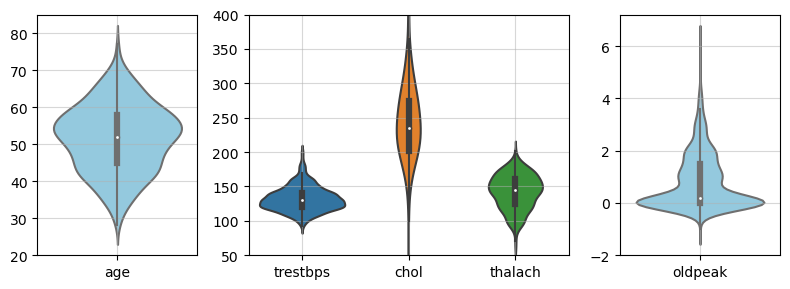

In [70]:
fig = plt.figure(figsize=(8, 3))
gs = GridSpec(1,3, width_ratios=[1,2,1])
ax1 = fig.add_subplot(gs[0])
sns.violinplot(df[['age']], ax=ax1, color='skyblue')
ax1.grid(alpha=0.5)

ax2 = fig.add_subplot(gs[1])
sns.violinplot(df[cols_to_describe].drop(columns=['age','oldpeak']), ax=ax2)
ax2.grid(alpha=0.5)
ax2.set_ylim([50,400])

ax3 = fig.add_subplot(gs[2])
sns.violinplot(df[['oldpeak']], ax=ax3, color='skyblue')
ax3.grid(alpha=0.5)

plt.tight_layout()
plt.show()

In [71]:
df[['age','trestbps','chol','thalach','oldpeak']].corr()

,age,trestbps,chol,thalach,oldpeak
age,1.000000,0.257687,-0.032169,-0.325355,0.231476
trestbps,0.257687,1.000000,0.034147,-0.138136,0.186991
chol,-0.032169,0.034147,1.000000,0.202955,0.114410
thalach,-0.325355,-0.138136,0.202955,1.000000,-0.206474
oldpeak,0.231476,0.186991,0.114410,-0.206474,1.000000


The numerical varaibles are not highly-correlated with one another.

### Visual inspection of categorical variables

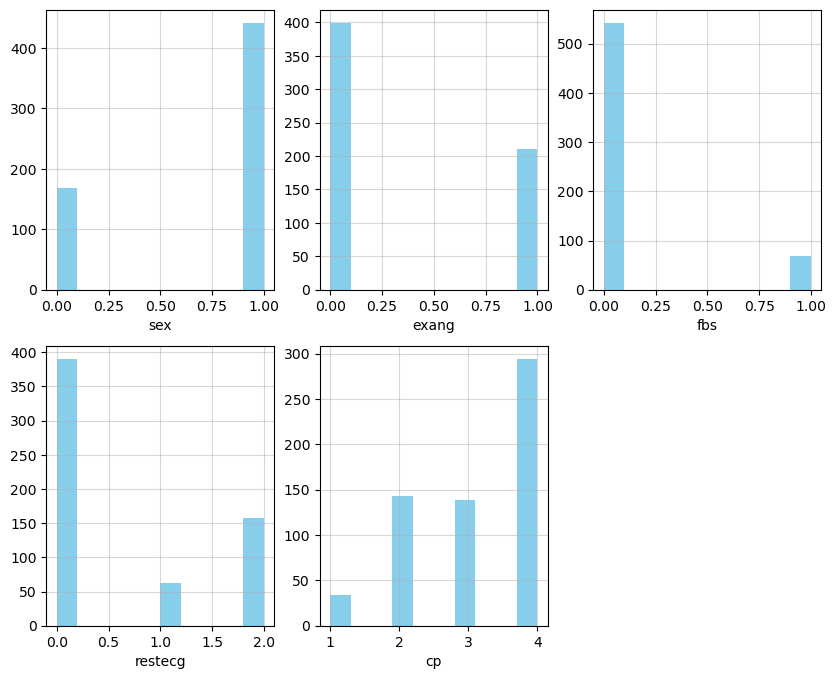

In [72]:
# visualize categorical variables
df_cat = df.drop(columns=cols_to_describe)
df_cat.drop(columns='diagnosis', inplace=True)
fig, ax = plt.subplots(2,3, figsize=(10,8))
cat_cols = df_cat.columns

[df_cat[cat_cols[i]].hist(color='skyblue', ax=ax[i%2,i%3]) for i in range(0,len(cat_cols))];
[ax[i%2,i%3].set_xlabel(cat_cols[i]) for i in range(0,len(cat_cols))];
[ax[i%2,i%3].grid(alpha=0.5) for i in range(0,len(cat_cols))];
fig.delaxes(ax[1,2])

The only variables that would need **one-hot encoding** are: *cp* and *restceg*.

## 3. Machine Learning Model

In [73]:
X = df.drop(columns = 'diagnosis')
y = df['diagnosis']

# split the data into train and test sets to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [74]:
cat_features_to_encode = ["cp", "restecg"]
cat_features_no_encode = ["sex","exang","fbs"]
X_train_categorical = X_train[cat_features_to_encode].copy()

ohe = OneHotEncoder(sparse_output=False, feature_name_combiner='concat', drop='first')
ohe.fit(X_train_categorical)

X_train_ohe = pd.DataFrame(
    ohe.transform(X_train_categorical),
    # index is important to ensure we can concatenate with other columns
    index=X_train_categorical.index)
X_train_ohe.rename(columns={0:'cp_2', 1:'cp_3', 2:'cp_4', 3:'restecg_1', 4:'restecg_2'}, inplace=True)
X_train_ohe = pd.concat([X_train[cat_features_no_encode],X_train_ohe], axis=1)

display(X_train_ohe.head())

## repeat same procedure on X_test
X_test_categorical = X_test[cat_features_to_encode].copy()
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test_categorical),
    # index is important to ensure we can concatenate with other columns
    index=X_test_categorical.index)
# X_test_ohe.rename(columns={0:'cp_1', 1:'cp_2', 2:'cp_3', 3:'cp_4', 4:'restecg_0', 5:'restecg_1', 6:'restecg_2' }, inplace=True)
X_test_ohe.rename(columns={0:'cp_2', 1:'cp_3', 2:'cp_4', 3:'restecg_1', 4:'restecg_2'}, inplace=True)
X_test_ohe = pd.concat([X_test[cat_features_no_encode],X_test_ohe], axis=1)
display(X_test_ohe.head())

,sex,exang,fbs,cp_2,cp_3,cp_4,restecg_1,restecg_2
88,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
187,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
117,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,sex,exang,fbs,cp_2,cp_3,cp_4,restecg_1,restecg_2
81,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
218,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
282,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
264,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


In [75]:
numeric_features = cols_to_describe
X_train_numeric = X_train[numeric_features].copy()
display(X_train_numeric.head())

## repeat same procedure on X_test
X_test_numeric = X_test[numeric_features].copy()
display(X_test_numeric.head())

,age,trestbps,chol,thalach,oldpeak
88,53.0,138.0,234.0,160.0,0.0
187,62.0,140.0,271.0,152.0,1.0
117,35.0,138.0,183.0,182.0,1.4
49,41.0,120.0,295.0,170.0,0.0
76,45.0,120.0,225.0,140.0,0.0


,age,trestbps,chol,thalach,oldpeak
81,53.0,130.0,264.0,143.0,0.4
218,64.0,130.0,303.0,122.0,2.0
55,54.0,124.0,266.0,109.0,2.2
282,47.0,120.0,205.0,98.0,2.0
264,61.0,138.0,166.0,125.0,3.6


In [76]:
scaler = MinMaxScaler()

scaler.fit(X_train_numeric)
X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_numeric),
    # index is important to ensure we can concatenate with other columns
    index=X_train_numeric.index,
    columns=X_train_numeric.columns
)
display(X_train_scaled.head())

## perform same procedure on X_test
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_numeric),
    # index is important to ensure we can concatenate with other columns
    index=X_test_numeric.index,
    columns=X_test_numeric.columns
)
X_test_scaled.head()

,age,trestbps,chol,thalach,oldpeak
88,0.510204,0.425926,0.388060,0.746269,0.138889
187,0.693878,0.444444,0.449420,0.686567,0.277778
117,0.142857,0.425926,0.303483,0.910448,0.333333
49,0.265306,0.259259,0.489221,0.820896,0.138889
76,0.346939,0.259259,0.373134,0.597015,0.138889


,age,trestbps,chol,thalach,oldpeak
81,0.510204,0.351852,0.437811,0.619403,0.194444
218,0.734694,0.351852,0.502488,0.462687,0.416667
55,0.530612,0.296296,0.441128,0.365672,0.444444
282,0.387755,0.259259,0.339967,0.283582,0.416667
264,0.673469,0.425926,0.275290,0.485075,0.638889


In [77]:
X_train_full = pd.concat([X_train_scaled, X_train_ohe], axis=1)
display(X_train_full.head())

# perform same procedure on X_test
X_test_full = pd.concat([X_test_scaled, X_test_ohe], axis=1)
display(X_test_full.head())

,age,trestbps,chol,thalach,oldpeak,sex,exang,fbs,cp_2,cp_3,cp_4,restecg_1,restecg_2
88,0.510204,0.425926,0.388060,0.746269,0.138889,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
187,0.693878,0.444444,0.449420,0.686567,0.277778,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
117,0.142857,0.425926,0.303483,0.910448,0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49,0.265306,0.259259,0.489221,0.820896,0.138889,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
76,0.346939,0.259259,0.373134,0.597015,0.138889,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,age,trestbps,chol,thalach,oldpeak,sex,exang,fbs,cp_2,cp_3,cp_4,restecg_1,restecg_2
81,0.510204,0.351852,0.437811,0.619403,0.194444,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
218,0.734694,0.351852,0.502488,0.462687,0.416667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
55,0.530612,0.296296,0.441128,0.365672,0.444444,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
282,0.387755,0.259259,0.339967,0.283582,0.416667,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
264,0.673469,0.425926,0.275290,0.485075,0.638889,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0


### Logistic Regression

In [78]:
# def get_cross_val_summary(model, X_train,):

In [79]:
logreg_model = LogisticRegression(max_iter=1000, random_state = 42)

# cross-validation 

# Define the preprocessing pipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat_enc', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features_to_encode),
        ('cat_no_enc', 'passthrough', cat_features_no_encode)
    ])

pipeline = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', logreg_model)]
                   )
cv_scores = {key:0 for key in ['accuracy', 'precision', 'recall', 'f1']}
cv_scores['accuracy'] = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'accuracy').mean()
cv_scores['precision'] = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'precision').mean()
cv_scores['recall'] = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'recall').mean()
cv_scores['f1'] = cross_val_score(pipeline, X_train, y_train, cv=5, scoring = 'f1').mean()

print('CROSS-VALIDATION RESULTS - LOGISTIC REGRESSION MODEL:')
[print(f'mean {key} score is: {round(cv_scores[key],2)}') for key in  ['accuracy', 'precision', 'recall', 'f1']];

CROSS-VALIDATION RESULTS - LOGISTIC REGRESSION MODEL:
mean accuracy score is: 0.81
mean precision score is: 0.8
mean recall score is: 0.75
mean f1 score is: 0.78


In [80]:
# test
logreg_model.fit(X_train_full,y_train)
y_pred = logreg_model.predict(X_test_full)

print('TEST RESULTS - LOGISTIC REGRESSION MODEL:')
print(f'test accuracy score is {round(accuracy_score(y_test, y_pred),2)}')
print(f'test precision score is {round(precision_score(y_test, y_pred),2)}')
print(f'test recall score is {round(recall_score(y_test, y_pred),2)}')
print(f'test f1 score is {round(f1_score(y_test, y_pred),2)}')

TEST RESULTS - LOGISTIC REGRESSION MODEL:
test accuracy score is 0.78
test precision score is 0.85
test recall score is 0.71
test f1 score is 0.77


In [81]:
# Get feature importance (coefficients)
coefficients = logreg_model.coef_[0]

# Match coefficients with feature names
feature_importance = pd.Series(coefficients, index=X_train_full.columns).sort_values(ascending=False)

print("Feature Importance in Logistic Regression:")
display(feature_importance)

Feature Importance in Logistic Regression:


oldpeak      2.063951
cp_4         1.315194
sex          1.262642
age          1.227251
exang        1.047705
trestbps     0.560058
fbs          0.408858
restecg_2    0.226884
restecg_1   -0.014473
cp_3        -0.313805
cp_2        -0.714208
chol        -1.137252
thalach     -1.721914
dtype: float64

### Decision Trees

It's not strictly required for categorical data to be encoded for decision trees to work. We will for now bypass one-hot encoding and will go back if we don't get the desired results.

In [82]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
# cross-validation
pipeline_clf = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', clf)])
cv_scores_clf = {key:0 for key in ['accuracy', 'precision', 'recall', 'f1']}
cv_scores_clf['accuracy'] = cross_val_score(pipeline_clf, X_train, y_train, cv=5, scoring = 'accuracy').mean()
cv_scores_clf['precision'] = cross_val_score(pipeline_clf, X_train, y_train, cv=5, scoring = 'precision').mean()
cv_scores_clf['recall'] = cross_val_score(pipeline_clf, X_train, y_train, cv=5, scoring = 'recall').mean()
cv_scores_clf['f1'] = cross_val_score(pipeline_clf, X_train, y_train, cv=5, scoring = 'f1').mean()

print('CROSS-VALIDATION RESULTS - DECISION TREE MODEL:')
[print(f'mean {key} score is: {round(cv_scores_clf[key],2)}') for key in  ['accuracy', 'precision', 'recall', 'f1']];

CROSS-VALIDATION RESULTS - DECISION TREE MODEL:
mean accuracy score is: 0.74
mean precision score is: 0.72
mean recall score is: 0.68
mean f1 score is: 0.7


In [83]:
# test
clf.fit(X_train_full, y_train)
y_pred_clf = clf.predict(X_test_full)

print('TEST RESULTS - DECISION TREE MODEL:')
print(f'test accuracy score is {round(accuracy_score(y_test, y_pred_clf),2)}')
print(f'test precision score is {round(precision_score(y_test, y_pred_clf),2)}')
print(f'test recall score is {round(recall_score(y_test, y_pred_clf),2)}')

TEST RESULTS - DECISION TREE MODEL:
test accuracy score is 0.73
test precision score is 0.75
test recall score is 0.72


**Hyperparameter Tuning**

In [84]:
pipeline_clf_tuning = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=42))])
# Define the parameter grid
param_grid = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

# grid search with cross-validation
grid_search = GridSearchCV(pipeline_clf_tuning,  param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and the best cross-validation score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Best cross-validation score: 0.7573339703774487


In [85]:
best_params = grid_search.best_params_
best_params_stripped = {key.replace('classifier__',''): value for key,value in best_params.items()}
best_dectree = DecisionTreeClassifier(criterion='entropy', random_state=42, **best_params_stripped)

In [86]:
# repeat cross-validation
pipeline_best_dectree = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', best_dectree)])

metrics = ['accuracy','precision', 'recall', 'f1']
cv_scores_best_dectree = {key:0 for key in metrics}

for metric in metrics:
    cv_scores_best_dectree[metric] = round(cross_val_score(pipeline_best_dectree, X_train, y_train, cv=5, scoring = metric).mean(),2)

print('FINAL CROSS-VALIDATION RESULTS - DECISION TREE MODEL:')
print(cv_scores_best_dectree)

FINAL CROSS-VALIDATION RESULTS - DECISION TREE MODEL:
{'accuracy': 0.76, 'precision': 0.74, 'recall': 0.69, 'f1': 0.72}


In [87]:
# test 
best_dectree.fit(X_train_full, y_train)
y_pred_dectree = best_dectree.predict(X_test_full)

test_scores_best_dectree = {key:0 for key in metrics}

test_scores_best_dectree['accuracy'] = round(accuracy_score(y_test, y_pred_dectree),2)
test_scores_best_dectree['precision'] = round(precision_score(y_test, y_pred_dectree),2)
test_scores_best_dectree['recall'] = round(recall_score(y_test, y_pred_dectree),2)
test_scores_best_dectree['f1'] = round(f1_score(y_test, y_pred_dectree),2)

print('TEST RESULTS - DECISION TREE MODEL:')
test_scores_best_dectree

TEST RESULTS - DECISION TREE MODEL:


{'accuracy': 0.73, 'precision': 0.77, 'recall': 0.67, 'f1': 0.72}

Even using hyperparameter tuning, we cannot imrprove the performance of the model by much using this type of classifier. 

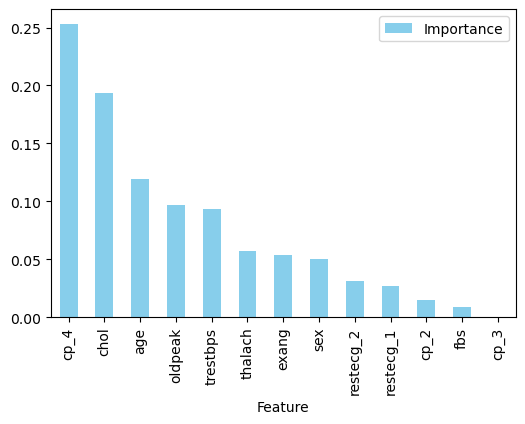

In [88]:
# Get feature importances

best_dectree.fit(X_train_full, y_train)
y_pred = best_dectree.predict(X_test_full)

feature_importances = best_dectree.feature_importances_
feature_names = X_train_full.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

fig,ax=plt.subplots(figsize=(6,4))
importance_df.plot(x='Feature',kind='bar', color='skyblue', ax=ax);

## Random Forest

In [89]:
rf = RandomForestClassifier(random_state=42)

# cross-validation
pipeline_rf = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', rf)])
cv_scores_rf = {key:0 for key in ['accuracy', 'precision', 'recall', 'f1']}
cv_scores_rf['accuracy'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring = 'accuracy').mean()
cv_scores_rf['precision'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring = 'precision').mean()
cv_scores_rf['recall'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring = 'recall').mean()
cv_scores_rf['f1'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring = 'f1').mean()

print('CROSS-VALIDATION RESULTS - RANDOM FOREST MODEL:')
[print(f'mean {key} score is: {round(cv_scores_rf[key],2)}') for key in  ['accuracy', 'precision', 'recall', 'f1']];

CROSS-VALIDATION RESULTS - RANDOM FOREST MODEL:
mean accuracy score is: 0.82
mean precision score is: 0.82
mean recall score is: 0.75
mean f1 score is: 0.78


In [90]:
# test
rf.fit(X_train_full, y_train)
y_pred_rf = rf.predict(X_test_full)

print('TEST RESULTS - RANDOM FOREST MODEL:')
print(f'test accuracy score is {round(accuracy_score(y_test, y_pred_rf),2)}')
print(f'test precision score is {round(precision_score(y_test, y_pred_rf),2)}')
print(f'test recall score is {round(recall_score(y_test, y_pred_rf),2)}')
print(f'test recall score is {round(f1_score(y_test, y_pred_rf),2)}')

TEST RESULTS - RANDOM FOREST MODEL:
test accuracy score is 0.78
test precision score is 0.82
test recall score is 0.73
test recall score is 0.77


**Hyperparameter Tuning**

In [91]:
# Define the model
pipeline_rf_tuning = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', RandomForestClassifier(random_state=42))])
# select parameter distribution
param_dist = {
    'classifier__n_estimators': randint(50,200),
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': randint(2, 10),
    'classifier__min_samples_leaf': randint(1, 4),
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
}

# Perform random search with cross-validation
random_search = RandomizedSearchCV(pipeline_rf_tuning, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)

In [93]:
random_search.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)
print("Best cross-validation score:", random_search.best_score_)

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 30, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 3, 'classifier__n_estimators': 173}
Best cross-validation score: 0.8206880076445293


In [94]:
# repeat cross-validation
best_params = random_search.best_params_
best_params_stripped = {key.replace('classifier__',''): value for key,value in best_params.items()}
best_rf = RandomForestClassifier(**best_params_stripped)

pipeline_best_rf = Pipeline(steps=[('preprocessing', preprocessor),
               ('classifier', best_rf)])

metrics = ['accuracy','precision', 'recall', 'f1']
cv_scores_best_rf = {key:0 for key in metrics}

for metric in metrics:
    cv_scores_best_rf[metric] = round(cross_val_score(pipeline_best_rf, X_train, y_train, cv=5, scoring = metric).mean(),2)

print('CROSS-VALIDATION RESULTS - RANDOM FOREST MODEL:')
print(cv_scores_best_rf)

CROSS-VALIDATION RESULTS - RANDOM FOREST MODEL:
{'accuracy': 0.81, 'precision': 0.82, 'recall': 0.76, 'f1': 0.78}


In [95]:
best_rf.fit(X_train_full, y_train)
y_pred_rf = best_rf.predict(X_test_full)
test_scores_best_rf = {key:0 for key in metrics}

test_scores_best_rf['accuracy'] = round(accuracy_score(y_test, y_pred_rf),2)
test_scores_best_rf['precision'] = round(precision_score(y_test, y_pred_rf),2)
test_scores_best_rf['recall'] = round(recall_score(y_test, y_pred_rf),2)
test_scores_best_rf['f1'] = round(f1_score(y_test, y_pred_rf),2)

print('TEST RESULTS - RANDOM FOREST MODEL:')
test_scores_best_rf

TEST RESULTS - RANDOM FOREST MODEL:


{'accuracy': 0.81, 'precision': 0.84, 'recall': 0.78, 'f1': 0.81}

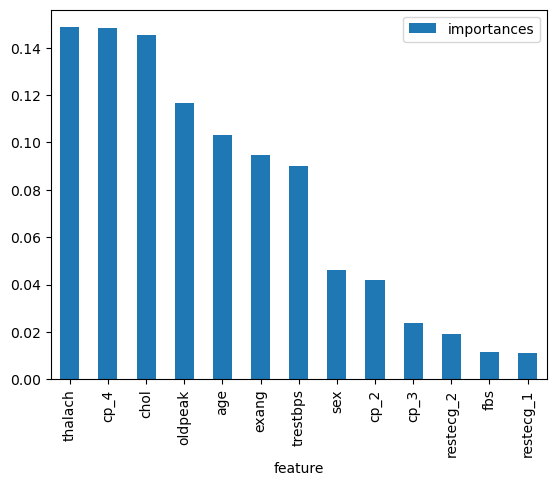

In [96]:
rf_feature_importance = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({'feature':feature_names, 'importances':rf_feature_importance})
rf_importance_df.sort_values(by='importances',ascending=False).plot(kind='bar', x='feature', y='importances');

## Results and Recommendations

The table below summarizes the performance of the models developed for cross-validation and test:

### Cross-validation results 

| Model   | Accuracy   | Precision  | Recall  | f1-score  | Top 5 Important Features |
|-----|---|---|---|------| --------- |
| Logistic Regression  | 0.81  | 0.80  | 0.75  | 0.78  | oldpeak, thalach, cp4, chol, sex |
| Decision Tree  | 0.76  | 0.74  | 0.69  |  0.72 | cp4, chol, age, oldpeak, trestbps |
| Random Forest  | 0.81  | 0.82  | 0.76  | 0.78  | thalach, cp-4, chol, oldpeak, age |

### Test results 

| Model   | Accuracy   | Precision  | Recall  | f1-score  | Top 5 Important Features |
|-----|---|---|---|------| --------- |
| Logistic Regression  | 0.78  | 0.85  | 0.71  | 0.77  | oldpeak, thalach, cp4, chol, sex |
| Decision Tree  | 0.73  | 0.77  | 0.67  |  0.72 | cp4, chol, age, oldpeak, trestbps |
| Random Forest  | 0.81  | 0.84  | 0.78  | 0.81  | thalach, cp-4, chol, oldpeak, age |

1. The random forest model has the best performance metrics among the tree tested. This is the model we should use for predicting whether a patient is prone to cardiovascular events that may need monitoring in the future. 
2. The following features are consistently listed as important by two or all classification algorithms:
    - cp4: asymptomatic chest pain type. 
    - chol: serum cholestoral in mg/dl. Elevated levels of cholestrol can cause buildup in the arteries and therefore are associated with heart disease. 
    - oldpeak: ST depression induced by exercise relative to rest. This factor is strongly associated with ischemia and can be a predictor of heart disease. 
    - thalch: maximum heart rate achieved. Lower peak heart rates during stress tests are often indicative of cardiovascular issues.
3. Age and sex are also among the other top-5 important features identified by the algorithms. 

## Limitations and Next Steps

1. The feature *oldpeak* has a heavily right-skewed distribution as shown in the plots above. Logistic regression assumes normal distribution for the features. Therefore its model assumptions are violated and its predictions may be inaccurate. Moreover, models like decision trees and the random forest method can get affected by such skewedness. In this case, outlier values can dominate the behavior of the model and affect the splits as well as feature importance. A more robust study would use techniques such as logarithmic transformation to reduce skewness in variables and then use them as features. 
2. In the context of this problem, having false positives is better than having false negatives since if a patient is flagged for susceptibility to heart disease, they will only need more check-ups. However, if they're not flagged while being high-risk, an unnoticed heart disease may occur with serious consequences for the patient. This means that recall is more important to us compared to precision. Therefore, one could repeat the hyperparameter tuning exercises using "recall" as the metric to optimize for.
3. Other powerful methods such as K-Means clustering or neural networks may be explored for improving the performance.